# Basis comparison
Compare reconstruction performance of different choices of basis:
* Raw input
* SVD/POD modes
* Random projections

We'll perform comparisons using Olivetti faces dataset from AT&T.

In [1]:
from time import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

import pysensors as ps

## Setup

Data consists of 10 pictures of 40 different people, each 64 x 64.

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

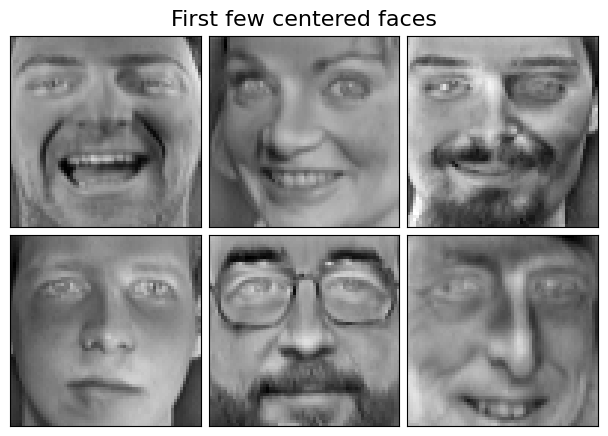

In [5]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [6]:
X_train, X_test = X[:300], X[300:]

## Reconstruction error

### Varying the number of basis modes
First we'll fix the number of sensors at 100 and see how the number of basis modes used affects the reconstruction error.

In [7]:
max_basis_modes = 200
n_sensors = 100
U = np.random.random((4096, max_basis_modes))

models = [
    (
        'Identity',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.Identity(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'SVD',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.SVD(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'Random Projection',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.RandomProjection(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'Custom Basis',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.Custom(U=U, n_basis_modes=max_basis_modes)
        )
    )
]

For the custom basis, we use a randomly generated basis of required shape filled with values between $1$ and $2$. This custom basis is user specific and can be any basis matrix that the user defines. For example, for time dependant problems, a user can use DMD bases.

Train time for Identity basis: 0.008975744247436523
Train time for SVD basis: 1.2285897731781006
Train time for Random Projection basis: 0.024204492568969727
Train time for Custom Basis basis: 5.7220458984375e-06


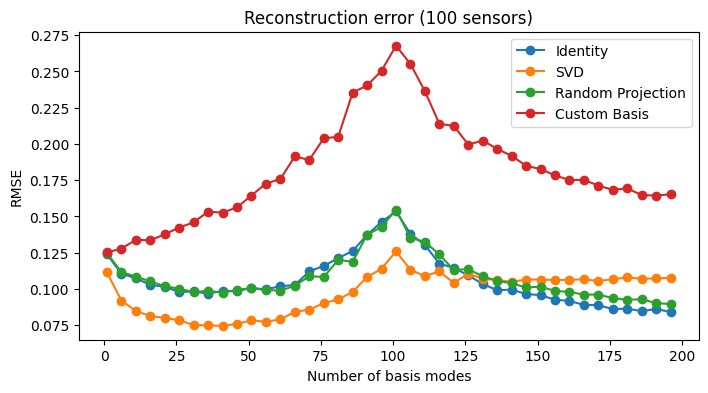

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of basis modes",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_sensors} sensors)",
)

n_basis_modes_range = np.arange(1, 200, 5)

# Suppress warning arising from selecting fewer basis modes than
# the number of examples passed to the Identity basis
# (results in some examples being thrown away)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for name, model in models:
        t0 = -time()
        model.basis.fit(X_train)
        print(f"Train time for {name} basis: {time() + t0}")

        errors = np.zeros_like(n_basis_modes_range, dtype=np.float64)
        for k, n in enumerate(n_basis_modes_range):
            model.update_n_basis_modes(n, X_test, quiet=True)
            errors[k] = model.reconstruction_error(X_test, [n_sensors])[0]

        ax.plot(n_basis_modes_range, errors, "-o", label=name)

ax.legend()
plt.show()

The Random projection and Identity bases give similar performance, with Identity winning out for larger numbers of modes. The POD basis performs best for smaller numbers of modes, but its accuracy tapers off as the number of basis modes grows large.

### Varying the number of sensors
Next we'll explore the reconstruction error for a fixed number of basis modes (100) as the number of **sensors** is varied.

In [9]:
n_basis_modes = 100

models = [
    (
        'Identity',
        ps.SSPOR(basis=ps.basis.Identity(n_basis_modes=n_basis_modes))
    ),
    (
        'SVD',
        ps.SSPOR(basis=ps.basis.SVD(n_basis_modes=n_basis_modes))
    ),
    (
        'Random Projection',
        ps.SSPOR(basis=ps.basis.RandomProjection(n_basis_modes=n_basis_modes))
    ),
    (
        'Custom Basis',
        ps.SSPOR(basis=ps.basis.Custom(U=U, n_basis_modes=n_basis_modes)
        )
    )
]

Train time for Identity basis: 0.10353565216064453
Train time for SVD basis: 0.7777824401855469
Train time for Random Projection basis: 0.26909589767456055
Train time for Custom Basis basis: 0.2307281494140625


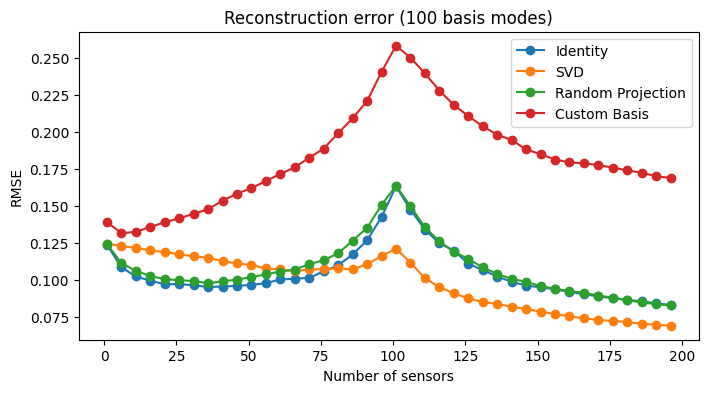

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of sensors",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_basis_modes} basis modes)",
)

sensor_range = np.arange(1, 200, 5)
for name, model in models:
    t0 = -time()
    model.fit(X_train, quiet=True)
    print(f"Train time for {name} basis: {time() + t0}")
    
    errors = model.reconstruction_error(X_test, sensor_range=sensor_range)
    ax.plot(sensor_range, errors, "-o", label=name)
    
ax.legend()
plt.show()

When the sensor count is small, Identity and Random projection bases produce the best reconstruction error. As the number of sensors grows, the POD basis wins out.

## Sensor locations
Let's compare the sensor locations for the four bases.

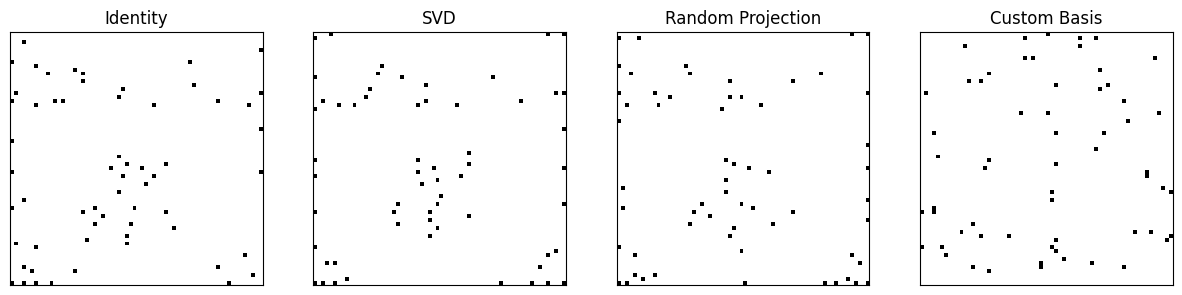

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
n_sensors = 60

for ax, (name, model) in zip(axs, models):
    img = np.zeros(n_features)
    sensors = model.get_all_sensors()[:n_sensors]
    img[sensors] = 16
    
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
    ax.set(title=name, xticks=[], yticks=[])

Similar sensor locations are chosen for this dataset across all four bases considered.